In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, callback
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

In [5]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [8]:
df = pd.read_csv("Data/hr_role.csv")
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


In [9]:
df = pd.get_dummies(df)
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,5993,...,False,False,True,False,False,False,True,True,False,True
1,49,0,279,8,1,3,61,2,2,5130,...,False,True,False,False,False,True,False,True,True,False
2,37,1,1373,2,2,4,92,2,1,2090,...,False,False,False,False,False,False,True,True,False,True
3,33,0,1392,3,4,4,56,3,1,2909,...,False,True,False,False,False,True,False,True,False,True
4,27,0,591,2,1,1,40,3,1,3468,...,False,False,False,False,False,True,False,True,True,False


In [10]:
target = 'Attrition'
y = df[target]

In [11]:
X = df.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
arbol2 = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

# Arbol Max Depth 2

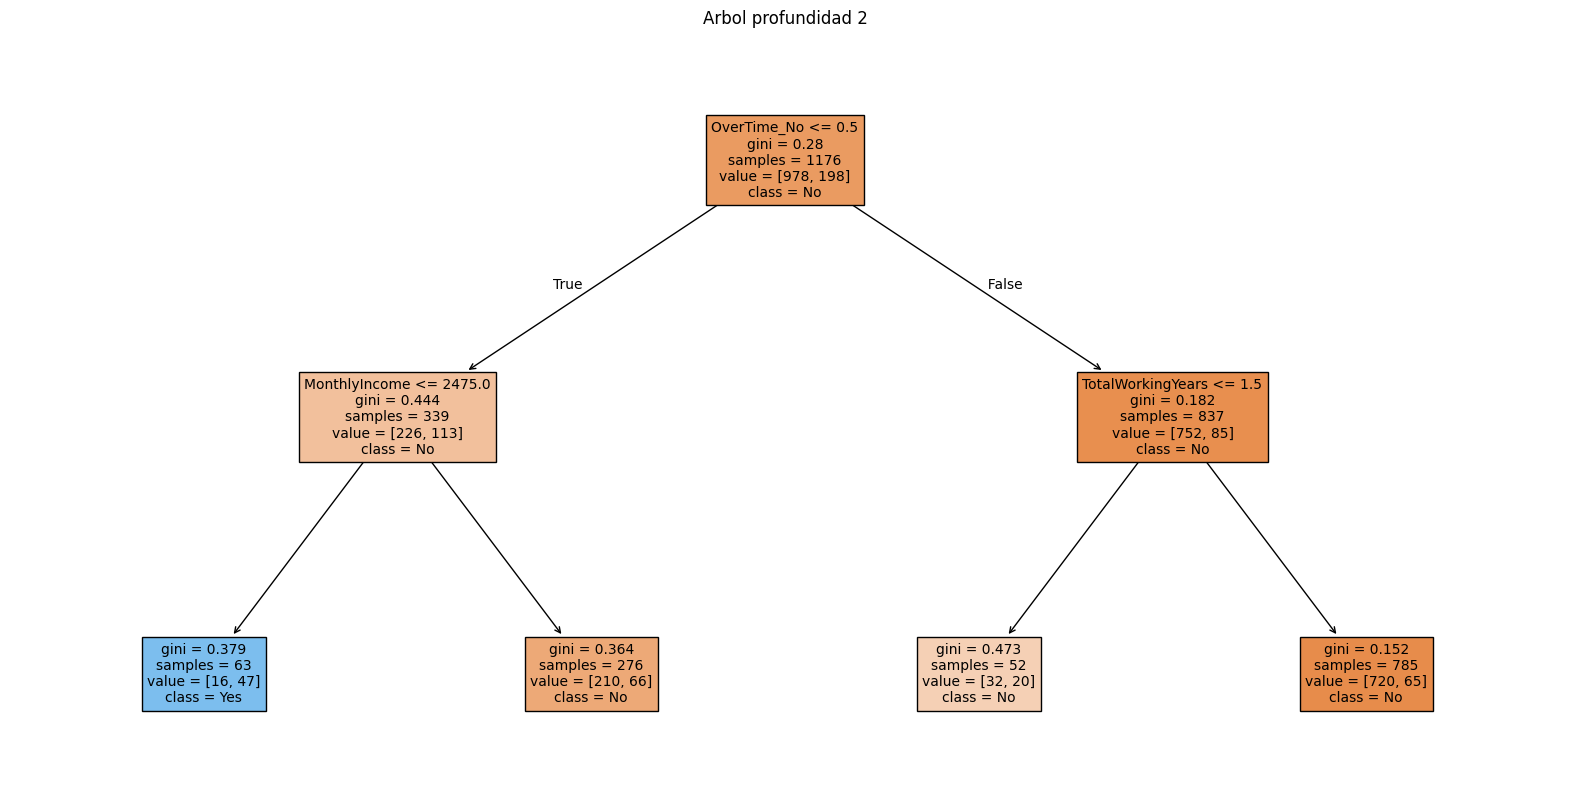

In [14]:
plt.figure(figsize=(20, 10))
plot_tree(arbol2, filled=True, feature_names=X.columns, class_names=["No", "Yes"], fontsize=10)
plt.title("Arbol profundidad 2")
plt.show()

# Mejor Arbol de Decision

In [16]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=42))
])

params = {
    'tree__max_depth': list(range(1, 10)),
    'tree__max_features': ['log2', 'sqrt', None],
    'tree__min_samples_split': list(range(2, 10)),
    'tree__min_samples_leaf': list(range(1, 10))
}

grid_tree = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='roc_auc')
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'tree__max_features': ['log2', 'sqrt', None],
                         'tree__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [ ]:
best_model = grid_tree.best_estimator_.named_steps['tree']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score = probabilidades, y_true=y_test)

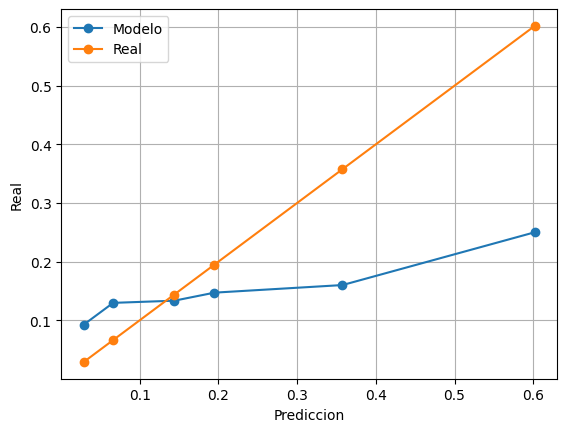

In [18]:
calibracion (probabilidades, y_test, 10)

In [19]:
roc_auc_score(y_test, probabilidades)

0.5947209653092006

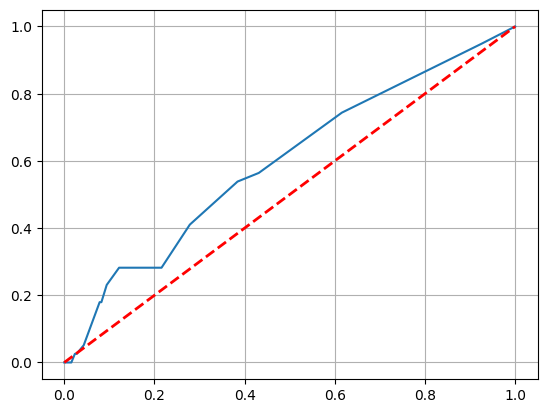

In [21]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

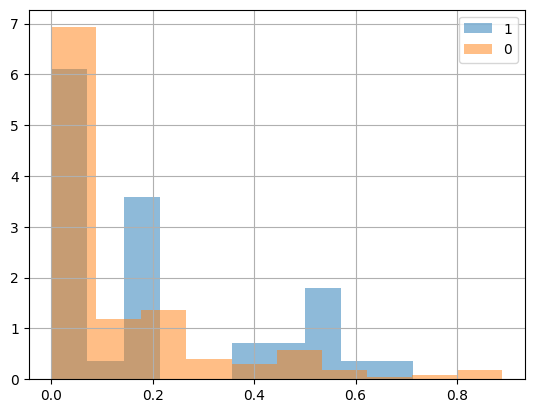

In [23]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

# Random Forest

In [28]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': list(range(1, 20)),
    'rf__max_features': ['log2', 'sqrt', 10, 12]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19],
                         'rf__max_features': ['log2', 'sqrt', 10, 12],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [29]:
best_model = rf_grid.best_estimator_.named_steps['rf']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score = probabilidades, y_true=y_test)

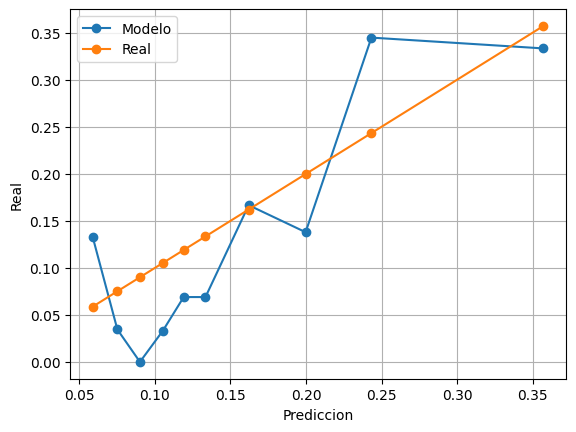

In [30]:
calibracion(probabilidades, y_test, 10)

In [32]:
auc_score = roc_auc_score(y_test, probabilidades)
auc_score

0.7319255907491201

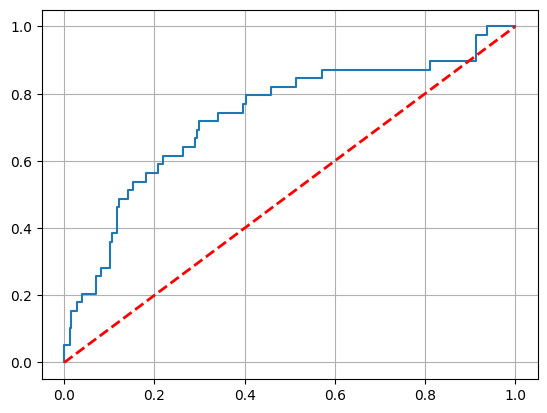

In [34]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

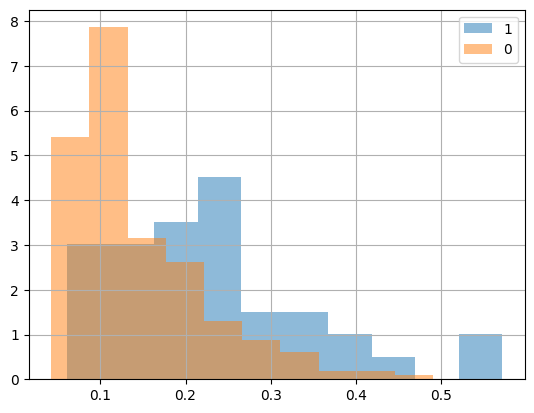

In [35]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

## Feature Importance Random Forest

In [36]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,0.048262
1,DailyRate,0.031662
2,DistanceFromHome,0.026513
3,Education,0.010120
4,EnvironmentSatisfaction,0.018033
5,HourlyRate,0.018770
6,JobInvolvement,0.018837
7,JobLevel,0.046603
8,MonthlyIncome,0.091207
9,MonthlyRate,0.025741


# XGBoost

In [45]:
model = XGBClassifier(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=100)


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'